# 2 - Molecular encoding

The RDKit descriptor is only one of several options. In this notebook we will look at various other descriptors available via the deepchem package (as its a nice API), and compare their predictive performance on this LogP problem. Then we move to a more challenging task, predicting biological activity against HIV1.

Note the term fingerprint, descriptor, embedding are used mostly interchangeably in the literature, and I may below too.

### Import Libraries

In [1]:
# general
import os
from multiprocessing import Pool
import random

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import deepchem as dc

2023-06-24 10:47:27.036954: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 10:47:27.944578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 10:47:27.954242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 10:47:31.449237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'

### Overview of some commonly used descriptors

- rdkit: various cheap to calculate statistics and models. Such as number of H-bond acceptor/donors, molweight, SLogP

- extended connectivity fingerprint (ecfp): This appraoch takes the set of molecules, and identifies the set of distinct functional groups containing n atoms (not including H or ions). i.e. if n is 3 then C=O-OH is legitimate, if n = 4 then CC=O-OH is a legitimate group. Each distinct group up to the mth most prevalent is then identified in molecules, and each molecule given a binary vector of length m, where m is 1 if group x is present, of 0 if abscent. See the image below.

- MACCS: These are a set of precomuted key functional groups. Think of it as a hardcoded ecfp.

- mordred: Modred can be thought of as a richly extended variant of the RDKit descriptors containing many more descriptor implementations from various publications. 


--- Representation of the ecfp and MACCS approach to fingerptinting. 
![substructure fingerptinting](lib/imgs/3_substr_fingerprint.png)

ref: https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics/06%3A_Molecular_Similarity/6.01%3A_Molecular_Descriptors

In [2]:
# define helper functions to help calculate vectors in parallel
def smiles_2_rdkitDescr(smiles):
    featurizer = dc.feat.RDKitDescriptors()
    return(featurizer(smiles).flatten())

def smiles_2_ecfp3(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

def smiles_2_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

def smiles_2_MACCS(smiles):
    featurizer = dc.feat.MACCSKeysFingerprint()
    return(featurizer(smiles).flatten())

def smiles_2_mordredDescr(smiles):
    featurizer = dc.feat.MordredDescriptors(ignore_3D=False)
    return(featurizer(smiles).flatten())  

In [3]:
# Now we generate the vector of vectors for each type of descriptor
df = pd.read_table('lib/data/1_logp.tsv')
y = df['Standard Value']

# rdkit descriptors - 208 total
with Pool(processes=os.cpu_count()) as p:
    x_rdkit = np.stack(p.map(smiles_2_rdkitDescr, df.Smiles.values))

# Extended fingerprint
with Pool(processes=os.cpu_count()) as p:
    x_ecfp3 = np.stack(p.map(smiles_2_ecfp3, df.Smiles.values))

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.Smiles.values))

# MACCS
with Pool(processes=os.cpu_count()) as p:
    x_MACCS = np.stack(p.map(smiles_2_MACCS, df.Smiles.values))

# Mordred - save this as its a long compute
with Pool(processes=os.cpu_count()) as p:
    x_mordred = np.stack(p.map(smiles_2_mordredDescr, df.Smiles.values))


So now we have a set of vectors per molecule, which is best? Well we need to write some code to test this.
For each descriptor let's build the same RF based model we did in notebook 1 with the same data, then we can compare like for like with only 1 independant variable.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# define a dict of ML algorithms
dict_algorithm = {
    "RF": RandomForestRegressor()
}

# define a dict of molvectors
dict_feats = {
    'x_rdkit': x_rdkit,
    'x_ecfp3': x_ecfp3,
    'x_ecfp4': x_ecfp4,
    'x_MACCS': x_MACCS,
    'x_mordred': x_mordred,
}

print('feature - algorithm - RMSE - r2')

# for each molvector type
for f, f_df in dict_feats.items():
    x_train, x_test, y_train, y_test = train_test_split(
        f_df,
        y,
        test_size=0.3,
        random_state=99)
    # for each algorithm
    for m, model_instantiation in dict_algorithm.items():
        model_instantiation.fit(x_train, y_train)
        test_preds = model_instantiation.predict(x_test)
        col1 = f
        col2 = m

        # predictive metrics
        col3 = mean_squared_error(y_test, test_preds)
        col4 = r2_score(y_test, test_preds)
        
        newrow = pd.DataFrame( [[col1, col2, col3, col4]] ,columns=['feat', 'model', 'RMSE', 'r2']) 
        print(newrow.to_string(index=False, header=False))

feature - algorithm - RMSE - r2
x_rdkit RF 0.621017 0.776011
x_ecfp3 RF 1.442533 0.479705
x_ecfp4 RF 1.437682 0.481454
x_MACCS RF 1.08545 0.608498
x_mordred RF 0.598566 0.784108


### stop and think

hmm so it looks like the RDKit descriptors are still good, but the modred descriptors are now optimal, makes sense it's essentially a richly extended set. A problem with this approach is that any given split may randomly be a simpler task for x descriptor. This is especially true of smaller datasets like ours. A  more rigorous test would be to run several test:train splits for each feature type and keep track of the mean perormance metrics. This is a good defailt approach to use.


Below is the same code as above, but now the performance metrics are the mean from 10 random draws.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import random

# define a dict of ML algorithms
dict_algorithm = {
    "RF": RandomForestRegressor()
}

# define a dict of molvectors
dict_feats = {
    'x_rdkit': x_rdkit,
    'x_ecfp3': x_ecfp3,
    'x_ecfp4': x_ecfp4,
    'x_MACCS': x_MACCS,
    'x_mordred': x_mordred,
}

print('feature - algorithm - RMSE - r2')

resample_num = 10

# for each molvector type
for f, f_df in dict_feats.items():

    # for each algorithm
    for m, model_instantiation in dict_algorithm.items():

        #traack metrics
        rmse_total = 0
        r2_total = 0

        for rep in range(resample_num):
            # each resmaple produces a novel dataset and model
            x_train, x_test, y_train, y_test = train_test_split(
                f_df,
                y,
                test_size=0.3,
                random_state=random.randint(1,999))
            model_instantiation.fit(x_train, y_train)

            # tot up metrics
            test_preds = model_instantiation.predict(x_test)
            col1 = f
            col2 = m
            rmse_total = rmse_total + mean_squared_error(y_test, test_preds)
            r2_total = r2_total + r2_score(y_test, test_preds)
        
        # get mean summary stats
        mean_rmse = rmse_total / resample_num
        mean_r2 = r2_total / resample_num

        newrow = pd.DataFrame( [[col1, col2, mean_rmse, mean_r2]] ,columns=['feat', 'model', 'RMSE', 'r2']) 
        print(newrow.to_string(index=False, header=False))

feature - algorithm - RMSE - r2


x_rdkit RF 0.318777 0.834437
x_ecfp3 RF 1.089937 0.363234
x_ecfp4 RF 1.002855 0.50083
x_MACCS RF 0.536519 0.7304
x_mordred RF 0.395375 0.794029


okay so rdkit is still very good, actually the top... that's not what we expect maybe this example is too simple and as we mentioned a high proportion of drkits descriptors are dedicated to LogP measures.

What happens if we move from this toy LogP example to something biologically complex like predicting inhibition of HIV1 protease? Here the inclusion of several LogP predictors within the descript might not be such an advantage....  

The attached data file includes all inhibitor data against the HIV1 protease, which we found by saerching via the target option insde CHEMBLS website. The values are all Ki, which is like an IC50 but is normalised for the protein concentraion in the assay, which often varies across labs. Out of the 3700 molecules only 200 will be used here, where each molecule has a Ki in nM range.

This is no longer a toy example but a real world situation:

In [6]:
# data cleaning - not all chembl entries are created equal
df = pd.read_table('lib/data/2_hiv_protease.tsv')

# some entries are missing label values
df = df[df['Standard Value'] > 0]

# there are duplicate values, let's get the mean Ki per smiles
df = pd.DataFrame( df.groupby(['Smiles'])['Standard Value'].mean() )

# now the Ki values are very diverse, let's take the log10 transform
data = {'smiles': df['Standard Value'].index,
        'pKi': np.log10(df['Standard Value'].values)}
df = pd.DataFrame(data)
df

,smiles,pKi
0,C#CCN1C(=O)N(CC#C)[C@H](Cc2ccccc2)[C@@H]2OC(C)...,1.342423
1,C#CCN1C(=O)N(CC#C)[C@H](Cc2ccccc2)[C@H](O)[C@@...,1.342423
2,C/C(=C\C(=O)N(C)[C@@H](Cc1ccccc1)[C@H](O)CN(Cc...,1.720490
3,C/C(=N/O)c1cccc(CN2C(=O)N(Cc3cccc(/C(C)=N/O)c3...,-1.744727
4,C/C(=N/O)c1cccc(CN2[C@H](COc3ccccc3)[C@H](O)[C...,0.531479
...,...,...
2524,O[C@H]1C[C@H](Cc2ccccc2)[C@H](O)[C@@H](Cc2cccc...,6.301030
2525,S=C(NCCOc1nc2cc(Cl)ccc2n2cccc12)Nc1ccc(Br)cn1,1.845098
2526,[N-]=[N+]=N[C@@H](Cc1ccccc1)[C@@H]1[C@@H](O)[C...,2.518514
2527,[N-]=[N+]=Nc1ccc(S(=O)(=O)Nc2cccc(C(c3c(O)oc4c...,0.414973


In [7]:
# Now we generate the vector of vectors for each type of descriptor
df = df[0:200]
y = df['pKi']

# rdkit descriptors - 208 total
with Pool(processes=os.cpu_count()) as p:
    x_rdkit = np.stack(p.map(smiles_2_rdkitDescr, df.smiles.values))

# Extended fingerprint
with Pool(processes=os.cpu_count()) as p:
    x_ecfp3 = np.stack(p.map(smiles_2_ecfp3, df.smiles.values))

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.smiles.values))

# MACCS
with Pool(processes=os.cpu_count()) as p:
    x_MACCS = np.stack(p.map(smiles_2_MACCS, df.smiles.values))

# Mordred - comment this block out to save time
with Pool(processes=os.cpu_count()) as p:
    x_mordred = np.stack(p.map(smiles_2_mordredDescr, df.smiles.values))


/home/oscar/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/oscar/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/oscar/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
# now let's apply our previous code to this problem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import random

# define a dict of ML algorithms
dict_algorithm = {
    "RF": RandomForestRegressor()
}

# define a dict of molvectors
dict_feats = {
    'x_rdkit': x_rdkit,
    'x_ecfp3': x_ecfp3,
    'x_ecfp4': x_ecfp4,
    'x_MACCS': x_MACCS,
    'x_mordred': x_mordred, # comment this out to save time
}

print('feature - algorithm - RMSE - r2')

resample_num = 5

# for each molvector type
for f, f_df in dict_feats.items():

    # for each algorithm
    for m, model_instantiation in dict_algorithm.items():

        #traack metrics
        rmse_total = 0
        r2_total = 0

        for rep in range(resample_num):
            # each resmaple produces a novel dataset and model
            x_train, x_test, y_train, y_test = train_test_split(
                f_df,
                y,
                test_size=0.3,
                random_state=random.randint(1,999))
            model_instantiation.fit(x_train, y_train)

            # tot up metrics
            test_preds = model_instantiation.predict(x_test)
            col1 = f
            col2 = m
            rmse_total = rmse_total + mean_squared_error(y_test, test_preds)
            r2_total = r2_total + r2_score(y_test, test_preds)
        
        # get mean summary stats
        mean_rmse = rmse_total / resample_num
        mean_r2 = r2_total / resample_num

        newrow = pd.DataFrame( [[col1, col2, mean_rmse, mean_r2]] ,columns=['feat', 'model', 'RMSE', 'r2']) 
        print(newrow.to_string(index=False, header=False))

feature - algorithm - RMSE - r2
x_rdkit RF 6.310693 0.174586
x_ecfp3 RF 4.970231 0.350718
x_ecfp4 RF 5.658704 -0.005237
x_MACCS RF 6.166902 0.311731
x_mordred RF 6.065861 0.226164


# Summary - what did we learn

Here in this problem we see that the rdkit descriptors has been outcompeted by one or more of the other descriptors (variability due to random train:test split seed value). This is more in line broadly with the literature, as ecfp, MACCS and mordred are popular.

This is a problem that is highly complex compared to the prevous LogP example. There are 200 datapoints compared to 100, the compounds are of a greater diversity in general, and a componds property is no longer contingent just on the molecule, but also the target site, ADME etc. We have no pre-baked algorithms that can get you close to the predicted value log aLogP can with our first LogP example. You have to experimentally measure this, sorry!

Here then we see that rdkit is outcompetedd, the 208 numebrs it uses are not containing as sufficient detail as the far richer MACCS and mordred descriptors. Althought ecfp curiously weren't that performant here, unable to outcompete rdkit despite their richer descriptioons of molecules. Then again thir downfall is their resolution, being binary rather than floating points.

The take home is that it's worth trying a few appraches to encoding your molecules into vectors.

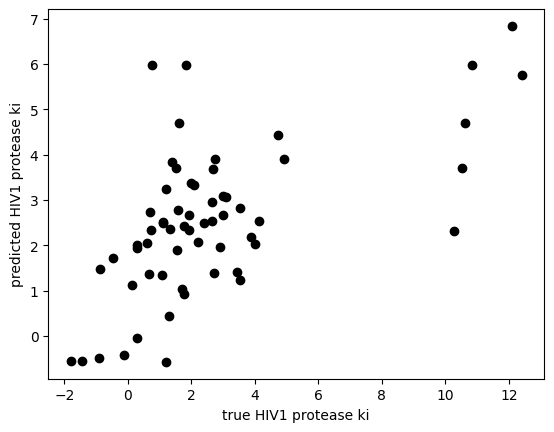

In [9]:
# for satisfaction let's look at the predicted vs experimental Ki values for that last RF modred model
plt.plot(y_test, test_preds, 'o', color='black');
plt.xlabel('true HIV1 protease ki');
plt.ylabel('predicted HIV1 protease ki');